In [1]:
import numpy as np

from helper_functions_tsp import read_file_name, validate_distance_array
from helper_functions_tsp import find_problem_size, cost_fn_fact
from helper_functions_tsp import read_index, hot_start
from helper_functions_tsp import convert_bit_string_to_cycle
from helper_functions_tsp import hot_start_list_to_string, update_parameters_using_gradient

from helper_functions_tsp import define_parameters, create_initial_rotations
from helper_functions_tsp import bind_weights, vqc_circuit,  cost_func_evaluate

from graph_functions import parameter_graph, cost_graph_multi

import copy

In [2]:
from modules.config import CONTROL_FILE, ENCODING, GRAPH_DIRECTORY, LOCATIONS, ROTATIONS, SHOTS
from modules.config import AVERAGE_SLICE, MODE, ITERATIONS, PRINT_FREQUENCY, GRAY, HOT_START
from modules.config import VERBOSE, GRADIENT_TYPE, S, ETA, ALPHA, GAMMA, C

## Read in the control file
The executions are controlled by a CSV parameter file in the control directory

In [3]:
control_dict = read_index(CONTROL_FILE, ENCODING)
print(control_dict)

{0: {'id': '0', 'locations': '5', 'mode': '1', 'eta': '0.005', 'updates': '50', 'print_frequency': '5', 'gray': '1', 'verbose': '1', 'optimiser': 'tbc'}, 1: {'id': '1', 'locations': '5', 'mode': '2', 'eta': '0.005', 'updates': '50', 'print_frequency': '5', 'gray': '1', 'verbose': '1', 'optimiser': 'tbc'}}


From the number of locations visited find the qubits and longest binary string.

In [4]:
bin_len, qubits = find_problem_size(LOCATIONS)
print(f'There are {qubits} qubits needed.  The longest binary string is {bin_len}')

There are 25 qubits needed.  The longest binary string is 4


Data sources are held locally to avoid downstream dependencies.

In [5]:
data_sources = {  4 : {'file' : 'data/four_d.txt', 'best' : 21},
                  5 : {'file' : 'data/five_d.txt', 'best' : 19},
                 11 : {'file' : 'data/dg11_d.txt', 'best' : 253},
                 15 : {'file' : 'data/p01_d.txt',  'best' : 291},
                 17 : {'file' : 'data/gr17_d.txt', 'best' : 2085},
                 26 : {'file' : 'data/fri26_d.txt', 'best' : 699},
                 42 : {'file' : 'data/dantzig42_d.txt', 'best' : 33_523},
                }

Read the data, and print out the filename and best distance held in the data.

In [6]:
filename = read_file_name(LOCATIONS, data_sources)
best_dist = data_sources[LOCATIONS]['best']
print(f'Data will be read from filename {filename}.  It is known that the shortest distance is {best_dist}.')

Data will be read from filename data/dg11_d.txt.  It is known that the shortest distance is 253.


Read and validate the distance array.  This checks the array is the correct shape, and is symmetric.

In [7]:
distance_array = np.genfromtxt(filename)
validate_distance_array(distance_array, LOCATIONS)

Define the VQC circuits with appropriate parameters, and draw the circuit.

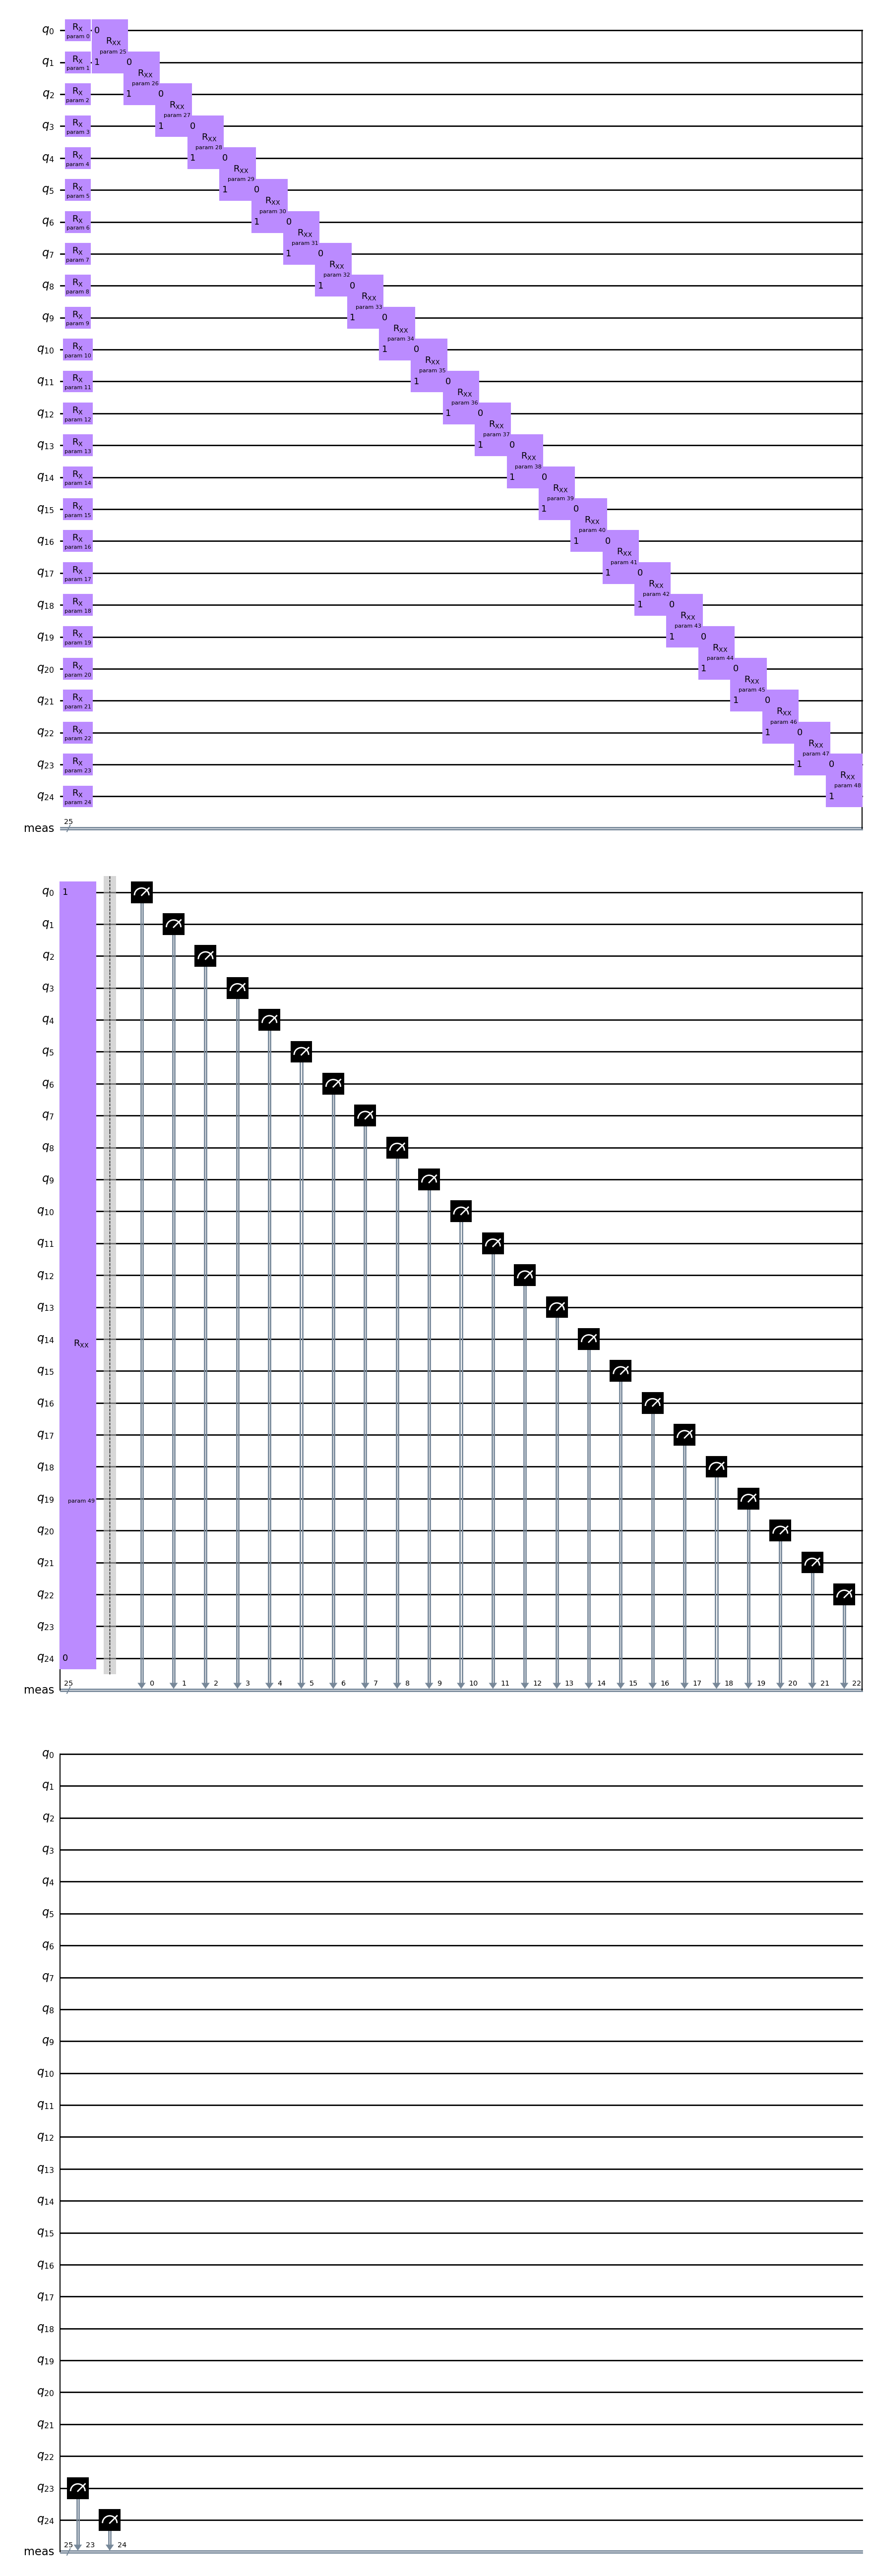

In [8]:
params = define_parameters(qubits, MODE)
qc = vqc_circuit(qubits, params, MODE)
qc.draw("mpl", style="clifford")

In [9]:
cost_fn = cost_fn_fact(LOCATIONS,distance_array, GRAY)

Iterate over the control parameters and do one experiment for each one of them.

Create random initial rotations, and bind these to the parameters in a new circuit `bc`.

The hot start location list is [0, 8, 7, 2, 10, 1, 4, 3, 5, 9, 6]
This is equivalent to a binary list: [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
The hot start distance is 299.0, compared to a best distance of 253.
The initial parameters (weights) are [3.14159265 0.         0.         0.         0.         3.14159265
 0.         0.         0.         0.         0.         3.14159265
 0.         3.14159265 3.14159265 0.         0.         3.14159265
 0.         3.14159265 0.         0.         0.         3.14159265
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


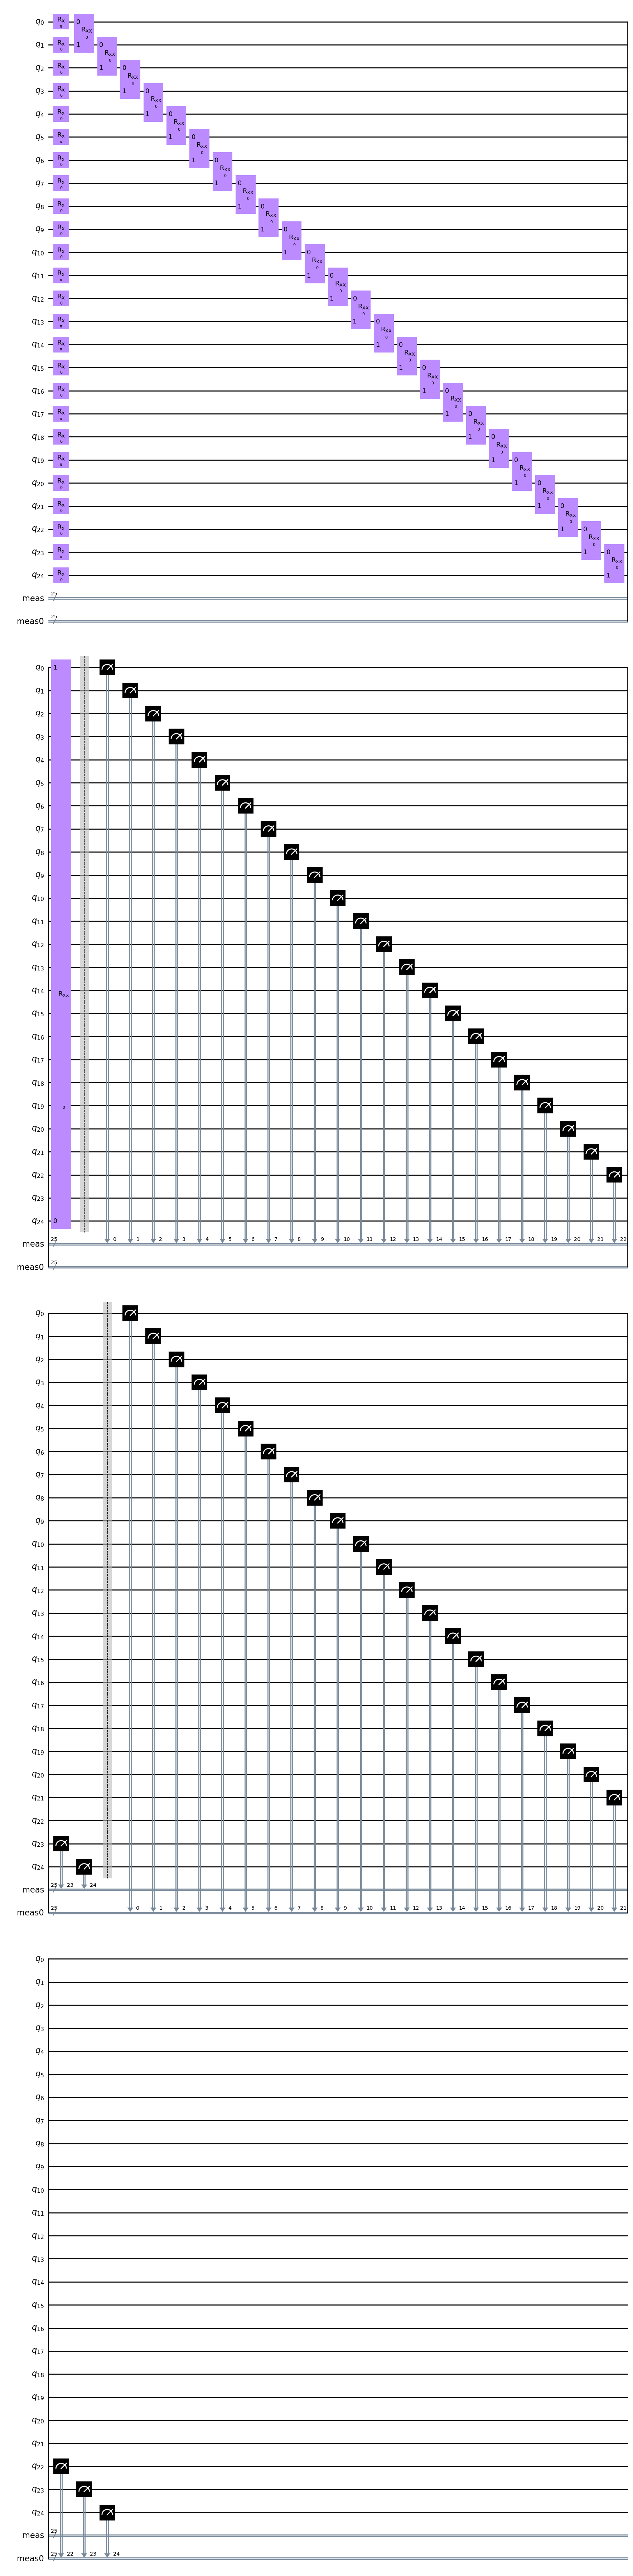

In [10]:
if HOT_START:
    hot_start_list = hot_start(distance_array, LOCATIONS)
    print(f'The hot start location list is {hot_start_list}')
    bin_hot_start_list =  hot_start_list_to_string(hot_start_list, LOCATIONS, GRAY)
    print(f'This is equivalent to a binary list: {bin_hot_start_list}')
    distance = cost_fn(bin_hot_start_list)
    print(f'The hot start distance is {distance}, compared to a best distance of {best_dist}.')
    init_rots = create_initial_rotations(qubits, MODE, bin_hot_start_list, HOT_START)
else:
    init_rots = create_initial_rotations(qubits, MODE)
print(f'The initial parameters (weights) are {init_rots}')
bc = bind_weights(params, init_rots, qc)
bc.measure_all()
bc.draw("mpl", style="clifford")

In [11]:
cost_start, lowest_to_date, _ = cost_func_evaluate(cost_fn, bc, shots=SHOTS, average_slice=AVERAGE_SLICE, verbose=VERBOSE)
print(f'For the starting circuit the average cost is {cost_start:.1f} and the lowest cost is {lowest_to_date:.1f}')

For the starting circuit the average cost is 299.0 and the lowest cost is 299.0


Next we test the impact of varying each parameter in turn on the average cost.

In [12]:
param_values = np.array([(i * 2 * np.pi) / (ROTATIONS-1) for i in range(ROTATIONS)])

In [13]:
cost_list_all, lowest_list_all, sliced_cost_list_all = [], [], []
if VERBOSE:
    print(f'init_rots = {init_rots}')
#need deep copy in case init_rots is changed
for i in range(2*qubits):
    rots = copy.deepcopy(init_rots)
    if VERBOSE:
        print(f'Processing parameter {i}')
        print(f'rots = {rots}, init_rots = {init_rots}')
    cost_list, lowest_list, sliced_cost_list  = [], [], []
    for angle in param_values:
        rots[i] = angle
        bc = bind_weights(params, rots, qc)
        sliced_cost, _ , _ = cost_func_evaluate(cost_fn, bc, SHOTS, average_slice=AVERAGE_SLICE, verbose=VERBOSE)
        cost, lowest, lowest_energy_bit_string = cost_func_evaluate(cost_fn, bc, SHOTS, average_slice=1, verbose=VERBOSE)
        route_list = convert_bit_string_to_cycle(lowest_energy_bit_string, LOCATIONS, gray=GRAY)
        cost_list.append(cost)
        lowest_list.append(lowest)
        sliced_cost_list.append(sliced_cost)
        if VERBOSE:
            print(f'For angle {angle} the cost is {cost}, the lowest cost found is {lowest}')
            print(f'The full parameter vector is {rots}')
            print(f'the lowest energy bit string is {lowest_energy_bit_string} and this corresponds to a route of {route_list}')
            print(f'The average is {cost} without slicing, and {sliced_cost} with slicing')
    cost_list_all.append(cost_list)
    lowest_list_all.append(lowest_list)     
    sliced_cost_list_all.append(sliced_cost_list)

c:\Users\DanielGoldsmith\python notebooks\TSP_VQC\graph_functions.py:78: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


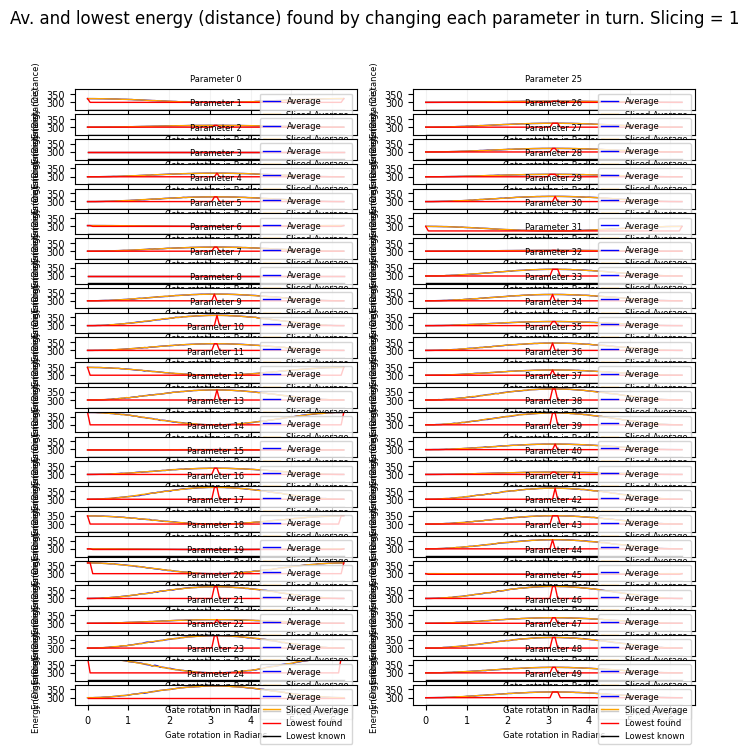

In [14]:
filename = GRAPH_DIRECTORY + 'Parameter_values'
main_title = f'Av. and lowest energy (distance) found by changing each parameter in turn. Slicing = {AVERAGE_SLICE}'
sub_title = 'Parameter '
x_label = 'Gate rotation in Radians'
param_names = [i for i in range(2*qubits)]
cost_graph_multi(filename, param_names, param_values, 
                 cost_list_all, lowest_list_all, sliced_cost_list_all, 
                 best_dist, main_title, sub_title, x_label)

In [15]:
index_l, sliced_l, lowest_l, gradient_l, average_l, parameter_l = \
    update_parameters_using_gradient(locations=LOCATIONS, iterations=ITERATIONS, 
                                    print_frequency=PRINT_FREQUENCY, params=params,
                                    rots=init_rots,  
                                    cost_fn=cost_fn, qc = qc, shots=SHOTS, s=S, 
                                    eta=ETA, average_slice=AVERAGE_SLICE, gray=GRAY, 
                                    verbose=VERBOSE, gradient_type=GRADIENT_TYPE,
                                    alpha=ALPHA, gamma=GAMMA, c=C
                                    )

For iteration 0 using the best 100 percent of the results
The average cost from the sample is 299.000 and the top-sliced average of the best results is 299.000
The lowest cost from the sample is 299.000
The lowest cost to date is 299.000 corresponding to bit string [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1] 
and route [0, 8, 7, 2, 10, 1, 4, 3, 5, 9, 6]
For iteration 100 using the best 100 percent of the results
The average cost from the sample is 300.121 and the top-sliced average of the best results is 300.060
The lowest cost from the sample is 271.000
The lowest cost to date is 270.000 corresponding to bit string [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1] 
and route [0, 8, 7, 2, 10, 1, 6, 4, 3, 9, 5]
For iteration 200 using the best 100 percent of the results
The average cost from the sample is 284.863 and the top-sliced average of the best results is 287.070
The lowest cost from the sample is 270.000
The lowest cost t

c:\Users\DanielGoldsmith\python notebooks\TSP_VQC\graph_functions.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


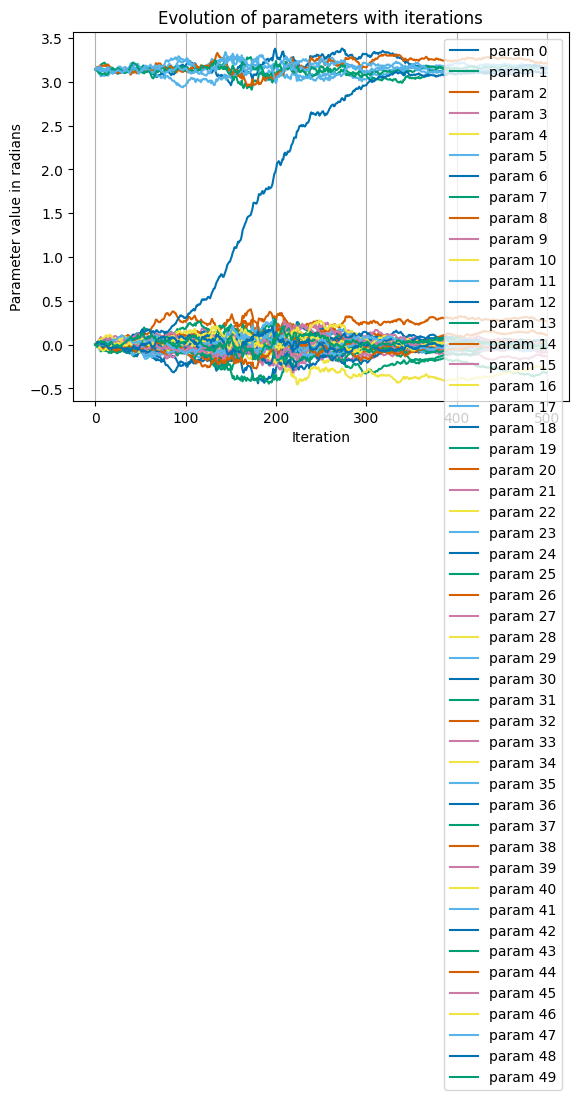

In [16]:
legend = [params[i].name for i in range(len(params))] 
filename = GRAPH_DIRECTORY+f'Evolution of parameters with iterations'
parameter_graph(filename, index_l, parameter_l, legend)

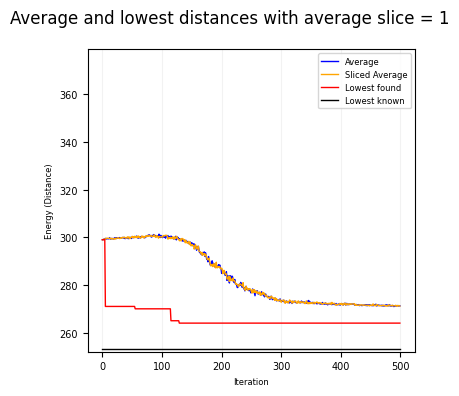

In [17]:
average_list_all = [average_l]
lowest_list_all = [lowest_l]
sliced_list_all = [sliced_l]
title = f'Average and lowest distances with average slice = {AVERAGE_SLICE}'
filename = GRAPH_DIRECTORY+title+'.png'
parameter_list = [AVERAGE_SLICE]
x_label = 'Iteration'
cost_graph_multi(filename, parameter_list, index_l, 
                 average_list_all, lowest_list_all, sliced_list_all,
                 best_dist, main_title=title, x_label=x_label, figsize = (4,4))

In [18]:
av_cost_list_all, lowest_list_all, sliced_cost_list_all = [], [], []
slices = [1, 0.75, 0.6, 0.5, 0.4, 0.25, 0.15, 0.05]
for slice in slices:
    cost_fn = cost_fn_fact(LOCATIONS, distance_array, gray=GRAY, verbose=VERBOSE)
    index_list, sliced_list, lowest_list, _ , average_list, _ = \
    update_parameters_using_gradient(locations=LOCATIONS, iterations=ITERATIONS, 
                                    print_frequency=PRINT_FREQUENCY, params=params,
                                    rots=rots,  
                                    cost_fn=cost_fn, qc = qc, shots=SHOTS, s=S, 
                                    eta=ETA, average_slice=slice, gray=GRAY, 
                                    verbose=VERBOSE, gradient_type=GRADIENT_TYPE,
                                    alpha=ALPHA, gamma=GAMMA, c=C)
    av_cost_list_all.append(average_list)
    lowest_list_all.append(lowest_list)
    sliced_cost_list_all.append(sliced_list)

For iteration 0 using the best 100 percent of the results
The average cost from the sample is 299.000 and the top-sliced average of the best results is 299.000
The lowest cost from the sample is 299.000
The lowest cost to date is 299.000 corresponding to bit string [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1] 
and route [0, 8, 7, 2, 10, 1, 4, 3, 5, 9, 6]
For iteration 100 using the best 100 percent of the results
The average cost from the sample is 298.680 and the top-sliced average of the best results is 300.689
The lowest cost from the sample is 264.000
The lowest cost to date is 264.000 corresponding to bit string [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1] 
and route [0, 8, 7, 2, 10, 1, 6, 3, 5, 9, 4]
For iteration 200 using the best 100 percent of the results
The average cost from the sample is 281.189 and the top-sliced average of the best results is 281.612
The lowest cost from the sample is 270.000
The lowest cost t

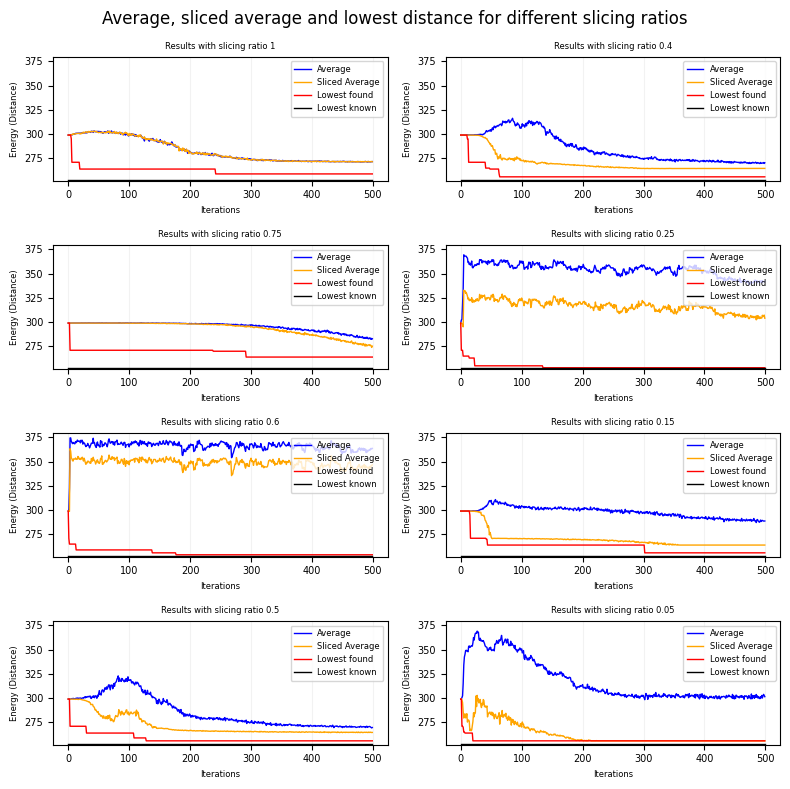

In [19]:
title = 'Average, sliced average and lowest distance for different slicing ratios'
filename = GRAPH_DIRECTORY+title+'.png'
sub_title = 'Results with slicing ratio '
x_label = 'Iterations'
cost_graph_multi(filename, slices, index_list, av_cost_list_all, 
                lowest_list_all, sliced_cost_list_all, 
                best_dist, title, sub_title,
                x_label
                )